In [1]:
from collections import Counter
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrum_painting as sp
import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load spectrograms

In [38]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you wrote.
reload(sp_data)

spectrograms = sp_data.load_spectrograms(data_dir="data/numpy",
                                         classes=["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"],
                                         snr_list=[10, 20, 30],
                                         # 20 MHz
                                         sample_rate=88000000,
                                         count=44000000)

In [37]:
reload(sp)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=sp_training.SpectrumPaintingTrainingOptions(
        spectrogram_length=2500,
        downsample_resolution=32,
        k=3,
        l=16,
        d=4,
        color_depth=256
    ),
    test_size=0.3
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")

Number of training images: 2013
Number of testing images: 864


[(0, 285), (1, 294), (2, 286), (3, 290), (4, 285), (5, 281), (6, 292)]
[(0, 126), (1, 117), (2, 125), (3, 121), (4, 126), (5, 130), (6, 119)]


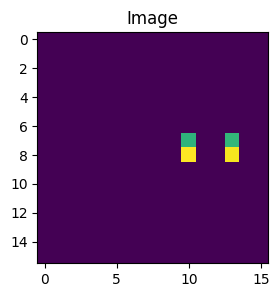

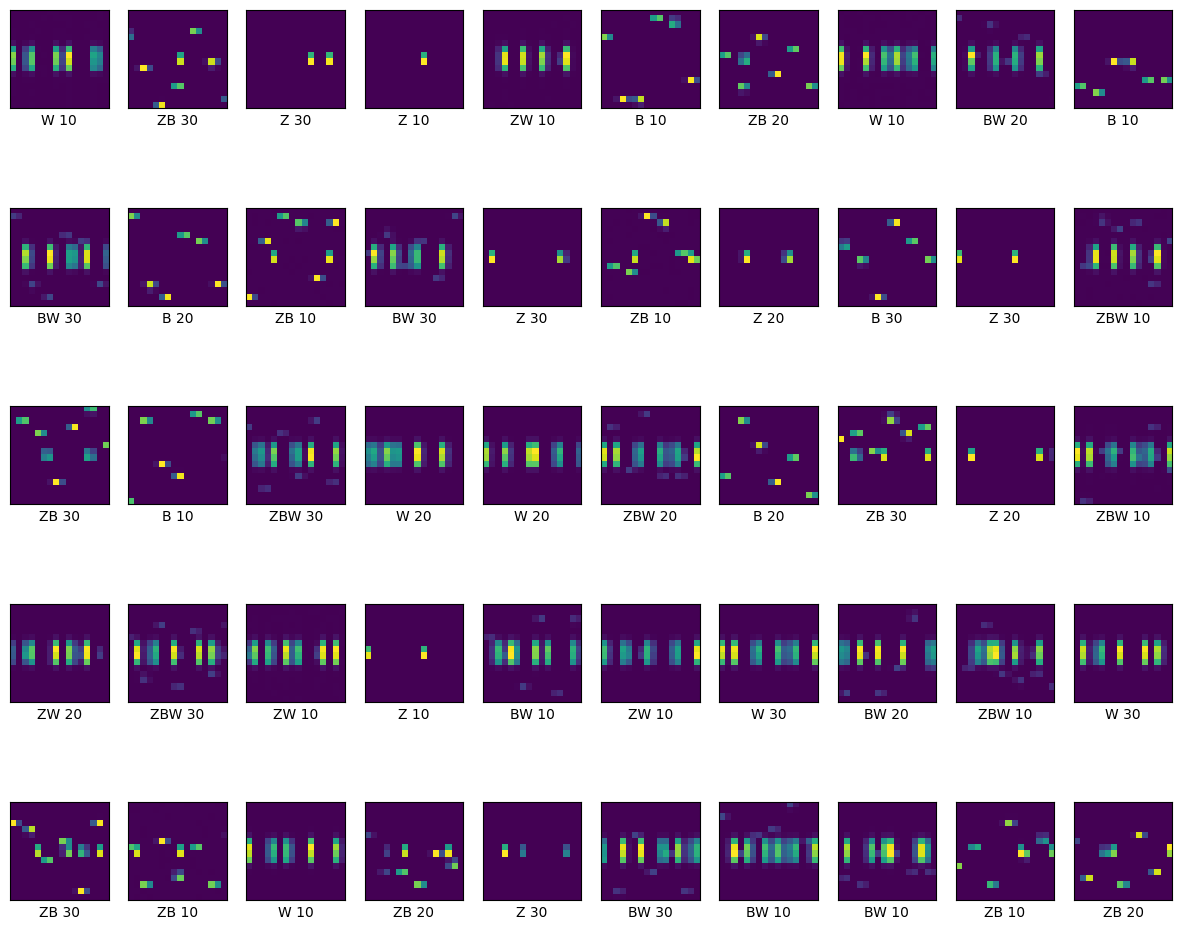

In [36]:
# Show the distribution
print(sorted(Counter(train_test_sets.y_train).items()))
print(sorted(Counter(train_test_sets.y_test).items()))

plt.figure(figsize=(3, 3))
plt.title("Image")
plt.imshow(train_test_sets.x_test_augmented[2], cmap='viridis')
plt.show()

sp_plot.plot_train_images(train_test_sets.x_test_painted,
                          train_test_sets.y_test,
                          train_test_sets.label_names,
                          train_test_sets.test_snr)

# Create TensorFlow model

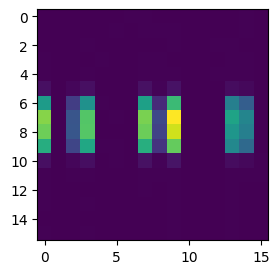

(16, 16)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 2)         100       
                                                                 
 batch_normalization_18 (Ba  (None, 16, 16, 2)         8         
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 8, 8, 2)           0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 2)           102       
                                                                 
 batch_normalization_19 (Ba  (None, 8, 8, 2)      

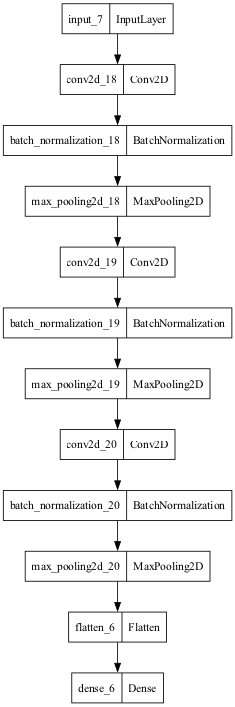

In [30]:
reload(sp_model)

plt.figure(figsize=(3, 3))
plt.imshow(train_test_sets.x_test_painted[0], cmap='viridis')
plt.show()

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model_one_channel(image_shape=image_shape,
                                                        label_count=len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


# Train the TensorFlow model

 Epoch: 52, Val. accuracy = 0.6701388955116272

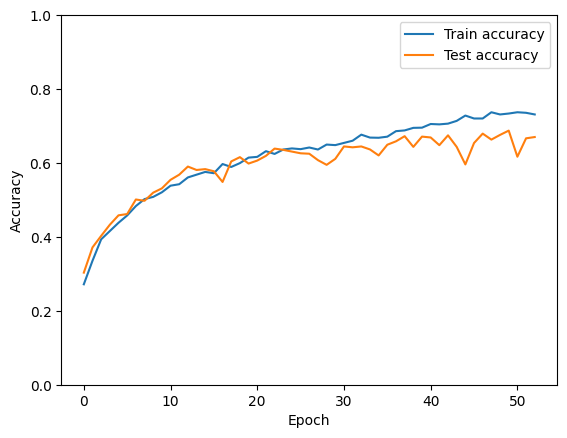

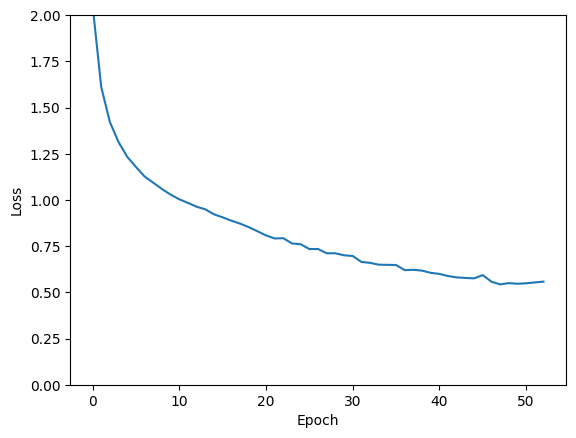

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


Final loss: 0.676102, final accuracy: 0.670139


In [31]:
reload(sp_model)
history = sp_model.fit_model_one_channel(tf_model, train_test_sets, epochs=100, early_stopping_patience=5)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

output_file = f"output/spectrum-painting-model-SNR-all.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


# Confusion matrix for TensorFlow model

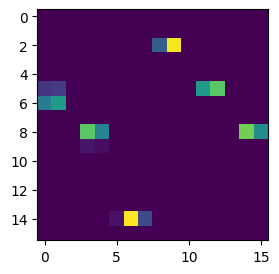

B


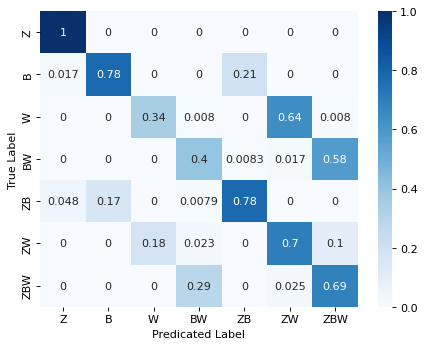

In [32]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img = train_test_sets.x_test_augmented[17]

plt.figure(figsize=(3, 3))
plt.imshow(test_img, cmap='viridis')
plt.show()

prediction = sp_predict.predict_full_model_one_channel(tf_model, test_img)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model_one_channel(tf_model, x) for x in
                          train_test_sets.x_test_augmented]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

# Convert to Lite model

In [34]:
reload(sp_model)
tflite_model = sp_model.convert_to_tensorflow_lite_one_channel(tf_model,
                                                               train_test_sets.x_test_augmented)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

lite_output_file = f"output/spectrum-painting-model.tflite"
# Save the model.
with open(lite_output_file, "wb") as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i $lite_output_file | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp1nji_83b/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp1nji_83b/assets


Done. Model size = 6 KB


2024-06-02 13:38:09.176522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-02 13:38:09.176538: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-02 13:38:09.176663: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp1nji_83b
2024-06-02 13:38:09.177719: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-02 13:38:09.177724: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp1nji_83b
2024-06-02 13:38:09.180712: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-02 13:38:09.214142: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp1nji_83b
2024-06-

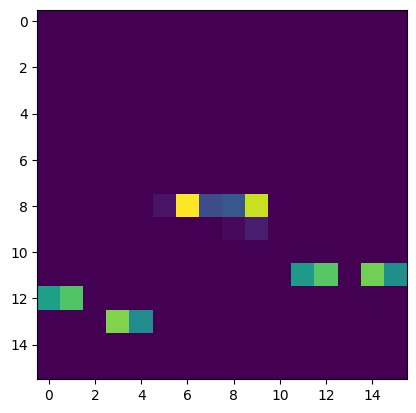

B


ValueError: Cannot set tensor: Got value of type UINT8 but expected type FLOAT32 for input 0, name: serving_default_input_7:0 

In [35]:
reload(sp_predict)
image_index = 9

# Test with Tensorflow Lite
test_img = train_test_sets.x_test_augmented[image_index]

plt.imshow(test_img, cmap="viridis")
plt.show()
print(train_test_sets.label_names[train_test_sets.y_test[image_index]])

prediction = sp_predict.predict_lite_model_one_channel(tflite_model, test_img)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

# Confusion matrix for Lite model

Lite model accuracy = 0.8958333333333334


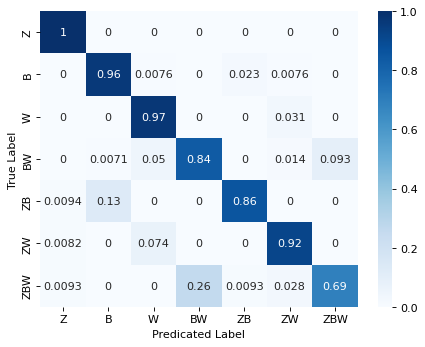

In [24]:
tflite_model_y_predictions: List[int] = []

for test_img in train_test_sets.x_test_augmented:
    prediction = sp_predict.predict_lite_model_one_channel(tflite_model, test_img)
    tflite_model_y_predictions.append(prediction)

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions),
                              train_test_sets.y_test,
                              train_test_sets.label_names)

# Test Lite model and save test images for Arduino

(32, 32)
Label index 2
Label W


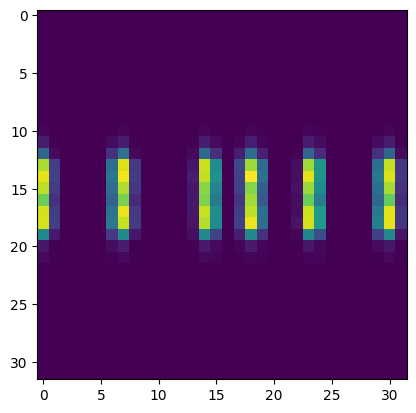

In [25]:
image_index = 0

test_img = train_test_sets.x_test_augmented[image_index]

print(test_img.shape)
print(f"Label index {train_test_sets.y_test[image_index]}")
print(f"Label {train_test_sets.label_names[train_test_sets.y_test[image_index]]}")

plt.imshow(test_img, cmap='viridis')
plt.show()

test_img.shape += (1,)
test_img = (np.expand_dims(test_img, 0))
test_img = test_img.astype(np.uint8)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img.flatten())

# Create a hex dump of the image in a C file for the arduino.
! xxd -i output/augmented_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/painted_image.h

# Compile and upload to arduino

In [27]:
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem2101

serial = Serial(port="/dev/cu.usbmodem2101", baudrate=9600, timeout=1000)

prediction = int(serial.readline().strip())
time = int(serial.readline().strip())
print(f"Full accuracy = {final_acc}")
print(f"Lite model size = {len(tflite_model) / 1000} KB, Lite accuracy = {tflite_accuracy}")
print(f"Prediction = {train_test_sets.label_names[prediction]}, Time = {time}ms")

Library Arduino_TensorFlowLite has been declared precompiled:
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4/fpv4-sp-d16-softfp" not found
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4" not found
Sketch uses 347184 bytes (35%) of program storage space. Maximum is 983040 bytes.
Global variables use 97168 bytes (37%) of dynamic memory, leaving 164976 bytes for local variables. Maximum is 262144 bytes.

Used library           Version     Path
Arduino_TensorFlowLite 2.4.0-ALPHA /Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite
Wire                               /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0/libraries/Wire

Used platform Version Path
arduino:mbed  3.3.0   /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0
Device       : nRF52840-QIAA
Version      : Arduino Bootloader (SAM-BA extended) 2.0 [Arduino:IKXYZ]
Address  